# Setup

### Imports

In [1]:
import os
import pandas as pd
import numpy as np
import torch
from matplotlib import pyplot as plt
import transformers
from datasets import load_dataset
from sklearn.metrics import f1_score

import sst
import utils
from sentiment_models import phi

In [2]:
# Configuration

transformers.utils.logging.set_verbosity_error()
utils.fix_random_seeds()

cpu_device = 'cpu'
gpu_device = 'cuda' if torch.cuda.is_available() else 'cpu'

plt.rcParams["figure.figsize"] = 10, 10

### Load Datasets

In [3]:
dyna_r1 = load_dataset("dynabench/dynasent", "dynabench.dynasent.r1.all")
dyna_r1_dev = dyna_r1['validation'].to_pandas()
# dyna_r1_test = dyna_r1['test'].to_pandas()
dyna_r2 = load_dataset("dynabench/dynasent", "dynabench.dynasent.r2.all")
dyna_r2_dev = dyna_r2['validation'].to_pandas()
# dyna_r2_test = dyna_r2['test'].to_pandas()
print(f'dyna_r1_dev.shape: {dyna_r1_dev.shape}')
print(f'dyna_r2_dev.shape: {dyna_r2_dev.shape}')

DEV_DATAFRAMES = [dyna_r1_dev, dyna_r2_dev]
# TEST_DATAFRAMES = [dyna_r1_test, dyna_r2_test]

print(f'Dev dataset length:  {sum([len(df) for df in DEV_DATAFRAMES])}')
# print(f'Test dataset length: {sum([len(df) for df in TEST_DATAFRAMES])}')

Reusing dataset dynabench_dyna_sent (C:\Users\Gabe\.cache\huggingface\datasets\dynabench___dynabench_dyna_sent\dynabench.dynasent.r1.all\1.1.0\ab89971d9ae1aacc59ed44d6855bf0e89167417257e2c2666f38e532148f2967)
100%|██████████| 3/3 [00:00<00:00, 428.16it/s]
Reusing dataset dynabench_dyna_sent (C:\Users\Gabe\.cache\huggingface\datasets\dynabench___dynabench_dyna_sent\dynabench.dynasent.r2.all\1.1.0\ab89971d9ae1aacc59ed44d6855bf0e89167417257e2c2666f38e532148f2967)
100%|██████████| 3/3 [00:00<00:00, 499.56it/s]

dyna_r1_dev.shape: (3600, 12)
dyna_r2_dev.shape: (720, 12)
Dev dataset length:  4320


### Load Saved Experiments

In [4]:
# TODO warn if not found
experiment_file_names = [
    'experiment_RoBERTa-Base (Baseline).pt',
    'experiment_RoBERTa-Base (AAN).pt',
    'experiment_DynaSent-M1 (Baseline).pt',
    'experiment_DynaSent-M1 (AAN).pt',
]

colors = ['orangered', 'orangered', 'dodgerblue', 'dodgerblue']
linestyles = [(0, (5, 1)), 'solid'] * 2
hatches = [(0, (5, 1)), 'solid'] * 2
    
experiments = []
for file_name, color, linestyle in zip(experiment_file_names, colors, linestyles):
    experiment = torch.load(os.path.join('models', file_name))
    # Force CPU to not run out of GPU memory with all models loaded
    experiment['model'].device = cpu_device
    experiment['model'].model.to(cpu_device)
    experiment['graph_color'] = color
    experiment['graph_linestyle'] = linestyle
    experiments.append(experiment)
    print(f'Loaded experiment for model {experiment["model"]}')

Loaded experiment for model RoBERTa-Base (Baseline)
Loaded experiment for model RoBERTa-Base (AAN)
Loaded experiment for model DynaSent-M1 (Baseline)
Loaded experiment for model DynaSent-M1 (AAN)


# 1. Quantitative Performance Evaluation

### Training Metrics

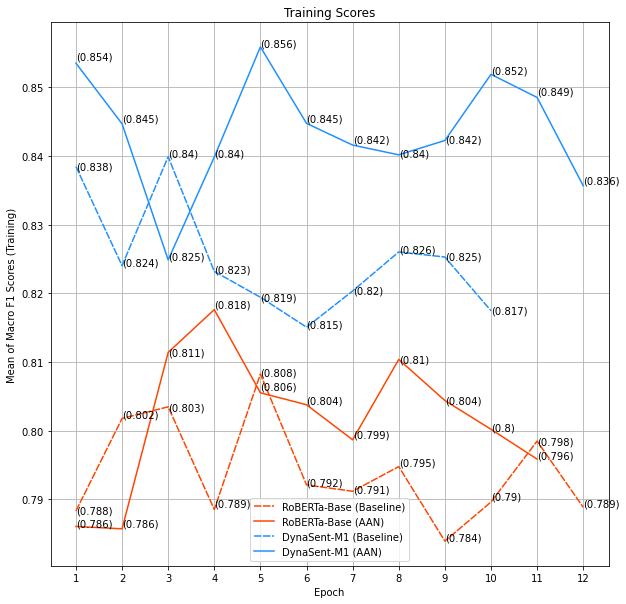

In [5]:
# Plot validation scores computed during training on held-out portions of the train set
for experiment, color, linestyle in zip(experiments, colors, linestyles):
    scores = experiment['model'].validation_scores
    epochs = list(range(1, len(scores) + 1))
    plt.plot(epochs, scores, label=f'{experiment["model"]}', color=color, linestyle=linestyle)
    # Data labels
    rounded_scores = [round(score, 3) for score in scores]
    for xy in zip(epochs, rounded_scores):
        plt.annotate('(%s)' % xy[1], xy=xy, textcoords='data')

plt.ylabel('Mean of Macro F1 Scores (Training)')
plt.xlabel('Epoch')
plt.title('Training Scores')
plt.grid()
plt.xticks(epochs)
plt.legend()


plt.show()


### Dev Set Evaluation

In [10]:
def evaluate_dataset(assess_df, score_func=utils.safe_macro_f1):
    # Build the dataset for assessment
    assess = sst.build_dataset(
        assess_df,
        phi,
        vectorize=False)

    # Run the model and assess the predictions
    scores = []
    for experiment in experiments:
        model = experiment['model']
        print(f'Evaluating {model}' , end =': ')
        # Move to GPU for faster processing
        model.device = gpu_device
        model.model.to(gpu_device)
        preds = model.predict(assess['X'])
        model.model.to(cpu_device)
        model.device = cpu_device
        
        score = score_func(assess['y'], preds)
        scores.append(score)
        print(score)

    return scores
    
    # Graph the results

In [12]:
dyna_r1_dev_scores = evaluate_dataset(dyna_r1_dev)

Evaluating RoBERTa-Base (Baseline): 0.6764826952914728
Evaluating RoBERTa-Base (AAN): 0.6852750178331574
Evaluating DynaSent-M1 (Baseline): 0.7564370208016715
Evaluating DynaSent-M1 (AAN): 0.7493122173239238


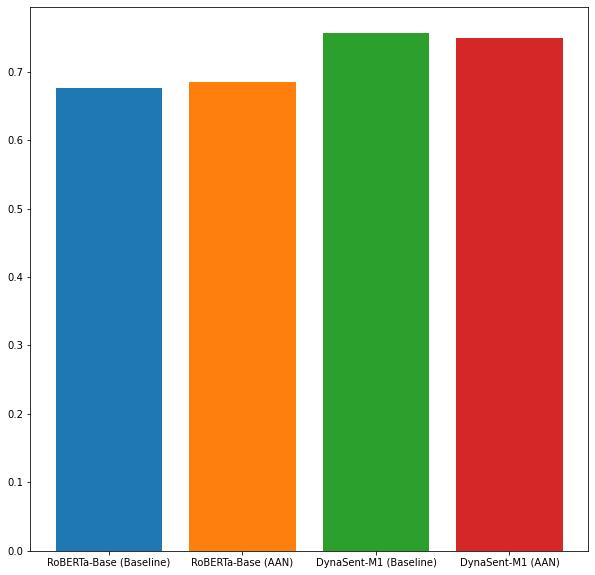

In [16]:
for experiment, score in zip(experiments, dyna_r1_dev_scores):
    plt.bar(str(experiment['model']), score)


In [11]:
evaluate_dataset(dyna_r2_dev)

Evaluating RoBERTa-Base (Baseline): 0.680659662958952
Evaluating RoBERTa-Base (AAN): 0.678933153299277
Evaluating DynaSent-M1 (Baseline): 0.6637254765274089
Evaluating DynaSent-M1 (AAN): 0.6583427463385975


[0.680659662958952, 0.678933153299277, 0.6637254765274089, 0.6583427463385975]

## Error analysis

This section begins to build an error-analysis framework using the dicts returned by `sst.experiment`. These have the following structure:

```
'model': trained model
'phi': the feature function used
'train_dataset':
   'X': feature matrix
   'y': list of labels
   'vectorizer': DictVectorizer,
   'raw_examples': list of raw inputs, before featurizing   
'assess_datasets': list of datasets, each with the same structure as the value of 'train_dataset'
'predictions': list of lists of predictions on the assessment datasets
'metric': `score_func.__name__`, where `score_func` is an `sst.experiment` argument
'score': the `score_func` score on the each of the assessment dataasets
```
The following function just finds mistakes, and returns a `pd.DataFrame` for easy subsequent processing:

In [ ]:
def find_errors(experiment):
    """Find mistaken predictions.

    Parameters
    ----------
    experiment : dict
        As returned by `sst.experiment`.

    Returns
    -------
    pd.DataFrame

    """
    dfs = []
    for i, dataset in enumerate(experiment['assess_datasets']):
        df = pd.DataFrame({
            'raw_examples': dataset['raw_examples'],
            'predicted': experiment['predictions'][i],
            'gold': dataset['y']})
        df['correct'] = df['predicted'] == df['gold']
        df['dataset'] = i
        dfs.append(df)
    return pd.concat(dfs)

In [ ]:
rnn_analysis = find_errors(rnn_experiment)

NameError: name 'rnn_experiment' is not defined

Here we merge the sotmax and RNN experiments into a single DataFrame:

In [ ]:
analysis = softmax_analysis.merge(
    rnn_analysis, left_on='raw_examples', right_on='raw_examples')

analysis = analysis.drop('gold_y', axis=1).rename(columns={'gold_x': 'gold'})

The following code collects a specific subset of examples; small modifications to its structure will give you different interesting subsets:

In [ ]:
# Examples where the softmax model is correct, the RNN is not,
# and the gold label is 'positive'

error_group = analysis[
    (analysis['predicted_x'] == analysis['gold'])
    &
    (analysis['predicted_y'] != analysis['gold'])
    &
    (analysis['gold'] == 'positive')
]

error_group.shape[0]

for ex in error_group['raw_examples'].sample(5, random_state=1):
    print("="*70)
    print(ex)

In [ ]:
def predict_one_rnn(text):
    # List of tokenized examples:
    X = [rnn_experiment['phi'](text)]
    # Standard `predict` step on a list of lists of str:
    # TODO be sure to change the model to eval mode before predicting
    preds = rnn_experiment['model'].predict(X)
    # Be sure to return the only member of the predictions,
    # rather than the singleton list:
    return preds[0]